In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

from IPython.core.display import HTML
HTML("<style>.container{ width: 100% !important; }</style>")

## training set

In [88]:
train = pd.read_csv('titanic/train.csv')
print("num records={}".format(train.shape[0]))
train.head()

num records=891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.describe()

'PassengerId' --id
 'Ticket',  --ticket #
 'Name', 
 'Cabin' --cabin #

--yhat
'Survived', --1 for survived

--dont use
 'Fare',  -- $ paid

--use
'Pclass', --values 1 for upper,2,3 for lower
 'SibSp',  -- # of sybilings?
 'Parch',  -- 0 for nanny
'Embarked' -- S, C or Q for port of embarkation

--use, needs buckets
 'Age',  --numeric 0 to 80 ish

--use, needs dummies
  'Sex', --male or female 

In [14]:
train[train.Parch==5].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S
638,639,0,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",female,41.0,0,5,3101295,39.6875,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q


In [9]:
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [3]:
# higher class pays MUCH more
train.groupby('Pclass').Fare.mean()

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

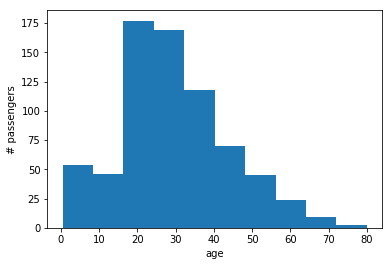

In [63]:
# can i do a stacked by color of age
plt.ylabel('# passengers')
plt.xlabel('age')
plt.hist(train.Age.dropna());

In [15]:
train[['Age']].dropna().sort_values('Age').Age.unique()

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,
        5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  ,
       14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 20.5 ,
       21.  , 22.  , 23.  , 23.5 , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 30.5 , 31.  , 32.  , 32.5 , 33.  ,
       34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  ,
       48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  , 55.5 ,
       56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 63.  , 64.  ,
       65.  , 66.  , 70.  , 70.5 , 71.  , 74.  , 80.  ])

In [132]:
def AgeCat (x):
    if x < 18:
        return 0
    elif x < 36:
        return 1
    elif x < 45:
        return 2
    elif x < 60:
        return 2
    else:
        return 2

train['AgeCat'] = train.Age.apply(lambda x: AgeCat(x))
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeCat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


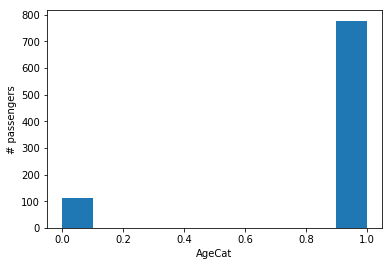

In [130]:
plt.ylabel('# passengers')
plt.xlabel('AgeCat')
plt.hist(train.AgeCat.dropna());

In [135]:
train1 = train.drop(['Fare','PassengerId','Ticket','Name','Cabin','Age','Embarked'],axis=1)
train1 = pd.get_dummies(train1,columns=['Sex','AgeCat'])
# train1 = train1.drop(['SibSp','Parch','AgeCat','Sex_female','Sex_male'],axis=1)
# train1 = train1.drop(['AgeCat'],axis=1)
train1.head()

,Survived,Pclass,SibSp,Parch,Sex_female,Sex_male,AgeCat_0,AgeCat_1,AgeCat_2
0,0,3,1,0,0,1,0,1,0
1,1,1,1,0,1,0,0,0,1
2,1,3,0,0,1,0,0,1,0
3,1,1,1,0,1,0,0,1,0
4,0,3,0,0,0,1,0,1,0


In [142]:
# Labels are the values we want to predict
labels = np.array(train1['Survived'])

# Remove the labels from the features
# axis 1 refers to the columns
features = np.array(train1.drop('Survived', axis = 1))

# Saving feature names for later use
# feature_list = list(train1.columns)

from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, \
                                                                            random_state = 42)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(train_features, train_labels);
predictions = rf.predict(test_features).astype('int')
# rf.score(predictions,test_labels)

errors = abs(predictions - test_labels)
print('Accuracy:', 1 - np.count_nonzero(errors) / errors.size)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Accuracy: 0.7219730941704036


In [8]:
bins = pd.IntervalIndex.from_tuples([(0, 1), (2, 3), (4, 5)])
# pd.cut([0, 0.5, 1.5, 5, 4.5], bins)
pd.cut([5], bins)
# [NaN, (0, 1], NaN, (2, 3], (4, 5]]
# Categories (3, interval[int64]): [(0, 1] < (2, 3] < (4, 5]]

Interval(4, 5, closed='right')